---
# Stellar Classifier
## By Gerald Meyers
---

This is an example model that classifies a data set of astronomical data and measures the accuracy against the provided labels. The models are implemented in Tensorflow models in a separate file `Stellar Classifiers.py`


In [ ]:
from utils import *

In [2]:
start_time = time( )

In [3]:
# set_option('mode.chained_assignment','warn')
set_option( 'mode.chained_assignment', None )

In [4]:
filterwarnings( 'ignore',
                # module='matplotlib\..*'
                )

In [5]:
local_directory = Path( '.' )
exam_question_csv = local_directory / 'Data' / 'exam_question.csv'
exam_raw_csv = local_directory / 'Data' / 'exam_raw.csv'

In [6]:
exam_raw_results = DataFrame( )
exam_question_results = DataFrame( )
exam_raw_outfile = local_directory / 'Data' / 'exam_raw_out.csv'
exam_question_outfile = local_directory / 'Data' / 'exam_question_out.csv'

In [7]:
exam_raw_data = read_csv( exam_raw_csv )
exam_question_data = read_csv( exam_question_csv )

len_exam_raw = len( exam_raw_data )
len_exam_question = len( exam_question_data )

In [8]:
##### There are 81940 data entries.
##### There are 1022 unique labels in the unfiltered SpType column.
uniques = unique( asarray( exam_raw_data[ 'SpType' ], dtype=str ) )
print( f"Length of raw_data is {len_exam_raw} \n"
       f"Length of raw_question is {len_exam_question} \n\n"
       f"Quantity of unique labels in SpTypes {len( uniques )}"
       )
uniques  # Uncomment to print table of uniques

Length of raw_data is 81940 
Length of raw_question is 623 

Quantity of unique labels in SpTypes 1022


array(['(G3w)F7', 'A', 'A0', ..., 'sdG5', 'sdG8', 'sdM4'], dtype='<U11')

### Some Helping Functions
---

The function `model_fit_test` is a general purpose abstraction for frequently used code and is built to make a pipeline, training data, testing data, and a name for the pipeline
and immediate fit the pipeline to the data, and make the testing results.

The function `model_scoring` takes the results of a model and tabulates the accuracy, precision, $r^2$, and mean square error.

The function `label_mapper` takes a label, a mapping, and preferred labels to prevent bad data from entering the training stream.

Finally, but written first, the metric functions are written into lambda functions and unpack a tuple of ground-truth labels and predicted labels, computing the error.

In [9]:
accracy = lambda x : f"{metrics.accuracy_score( *x ):.3%}"
precisn = lambda x : f"{metrics.precision_score( *x, average='weighted', zero_division=1 ):.3%}"
r_score = lambda x : f"{metrics.r2_score( *x, multioutput='uniform_average' ):.3%}"
meansqe = lambda x : f"{metrics.mean_squared_error( *x, multioutput='uniform_average' ):.3%}"

In [10]:
def label_mapper( label: str,
                  preferred_labels: list[ str ],
                  label_mapping: dict[ str : str ]
                  ) -> str :
    if label in label_mapping.keys( ) :
        return label_mapping[ label ]
    elif label in preferred_labels :
        return label
    else :
        raise ValueError( f'Label {label} is not a valid label' )

def model_scoring( model_name: str,
                   training: tuple,
                   testing: tuple,
                   *,
                   format='simple'
                   ) -> tabulate :
    return f'''{
    tabulate( { f"{model_name: >35}" : [ "Training Scores", "Testing Scores" ],
                "Accuracy"           : [ accracy( training ), accracy( testing ) ],
                "Precision"          : [ precisn( training ), precisn( testing ) ],
                "R score"            : [ r_score( training ), r_score( testing ) ],
                "Mean Square Error"  : [ meansqe( training ), meansqe( testing ) ], },
              headers="keys", tablefmt=format,
              )
    }\n'''

def model_fit_test( pipeline_elements: list[ tuple ],
                    training_data: [ tuple[ DataFrame ], list[ DataFrame ] ],
                    testing_data: [ tuple[ DataFrame ], list[ DataFrame ] ],
                    model_name: str = '',
                    ) -> list[ object, tuple[ str, tuple, tuple ] ] :

    # (training_features, training_labels) = training_data
    # (testing_features, testing_labels) = testing_data

    pipe = pipeline.Pipeline( pipeline_elements
                              ).fit( training_data[ 0 ], training_data[ 1 ], )
    return [ pipe,
             (model_name,
              (training_data[ 1 ], pipe.predict( training_data[ 0 ] )),
              (testing_data[ 1 ], pipe.predict( testing_data[ 0 ] )))
             ]


In [11]:
from inspect import signature

def call_func_with_kwargs( func: callable, **kwargs ) :
    '''https://stackoverflow.com/a/44052550/4122552'''
    sig = signature( func )
    filter_keys = [ param.name
                    for param in sig.parameters.values( )
                    if param.kind == param.POSITIONAL_OR_KEYWORD ]
    # if len(filter_keys) != 0 :
    #     print(filter_keys)
    return func( **{ key : kwargs[ key ]
                     for key in filter_keys
                     if key in kwargs.keys( ) } )
    # else:
    #     return func( **kwargs )

caller = call_func_with_kwargs

def make_model( transformer, model,
                train, test,
                name,
                transform_args: dict = None,
                model_args: dict = None,
                **kwargs
                ) :

    return model_fit_test( transformer( **transform_args )
                           + [ ('model', caller( model, **model_args )
                                ) ],
                           training_data=train, testing_data=test,
                           model_name=name
                           )

In [12]:
simple_plotting = lambda model, data, features, labels : classification_plots( model, data,
                                                                               features, labels,
                                                                               steps=100, plotsize=(4, 4) )

-<a
 href="https://blog.paperspace.com/numpy-optimization-vectorization-and-broadcasting/">
 We can use '%timeit' directly in jupyter to measure runtimes.
</a>

Example:

In [13]:
# #@formatter:off
# %timeit arange(100)
# #@formatter:on

-<a
href="https://www.annualreviews.org/doi/abs/10.1146/annurev.aa.11.090173.000333">
SPECTRAL CLASSIFICATION
By W. W. Morgan, P. C. Keenan
</a>
-<a
href="https://www.researchgate.net/publication/51964623_An_Encoding_System_to_Represent_Stellar_Spectral_Classes_in_ArchivalDatabases_and_Catalogs">
An Encoding System to Represent Stellar Spectral Classes in Archival Databases and Catalogs
By Myron A. Smith, Christopher J. Corbally, Et. Al.
</a>
-<a
href="https://astronomy.swin.edu.au/cosmos/m/morgan-keenan+luminosity+class">
Morgan-Keenan Luminosity Class
</a>


---
# Preprocessing the Data
---
<a href="https://en.wikipedia.org/wiki/Stellar_classification#History">Some history on stellar classifications can be read on wikipedia</a>. The Morgan-Keenan (Harvard) spectral classification system bases the label provided to stars purely on information derived from the spectrogram of a stellar observation. There are seven spectral classes. In descending order of temperature these are O B A F G K M, each of which is divided into 10 subclasses, numbered 0 through 9. The MK classification system has been extended with the various labels L T Y R S W.

Each label in the SpType column is mapped to one of the luminosity labels I-VII with a regex test. The SpType label passes the regex test by containing a complete and valid spectral classification at some point after the start of the string and by containing immediately adjacent a roman numeral. A non-capturing group is used to isolate the spectral classifier, while a simple Roman numeral capturing group is used to identify immediately adjacent roman numerals. The `re.compile` and `re.search` are used for this.

The feature vectors which fail this regex test and do not contain either or both a spectral and luminosity classification do not need to be explicitly dropped, and instead can be masked with a boolean matrix. Using this same tool we may create and combine additional masks to satisfy step 4.

The <a href="https://en.wikipedia.org/wiki/Stellar_classification#Yerkes_spectral_classification">Yerkes luminosity classes</a> are the Roman numerals that come with the spectral classifications. These are derived from the classes made by Angelo Secchi from the 1860s.
>- 0 or Ia+ -  hypergiants or extremely luminous supergiants
>- Ia - luminous supergiants
>- Iab - intermediate-size luminous supergiants
>- Ib - less luminous supergiants
>- II - bright giants
>- III - normal giants
>- IV - subgiants
>- V - main-sequence stars (dwarfs)
>- sd (prefix) or VI - subdwarfs
>- D (prefix) or VII - white dwarfs

A quick `ctrl-F` search in exam_raw.csv shows that most of the elements which have sd or D as a prefix do not contain a luminosity classification string. In fact there are only 12 'D' in the entire file. The file yields 22 'sd' which similarly do not contain luminosity classifications. Regex testing was made possible by <a href="https://regex101.com/">regex101.com</a>.

Originally the plan was to follow steps 1-6 for each problem. Due to sleep deprivation this seemed like a good plan. After catching a few more hours of sleep I reread the instructions and this is unnecessary.

The `exam_raw.csv` file is loaded and training and testing data is filtered from the clearly identifiable rows. The remaining data is not explicitly bad but may need to be imputed or lacks appropriate label for training or testing. A label is deemed to be good if it passes a regex search and is marked in a mask called good_data.

The `exam_question.csv` file is similarly loaded and imputed but contains no labels. It is solely used for external validation.

In [14]:
##### Steps 1,2,3 ##################################################################################################################
# Step 1 is the statement of the general problem: Map the SpType column to luminosity classifiers.
# Step 2 is the statement to remove features without a complete spectral classification.
# Step 3 is the statement to remove features without a complete luminosity classification.

# These can be summarized as filter data from set which does not match a well defined regex search.
# Attempting to _not_ use regex here is like trying to shoot yourself in the foot.
# Very easy and very painful.

# My foot hurts.

# stellar_classifier = compile( r'(?:[OBAFGKMRS][0-9])(IV|V?I{0,3})' ) # No matches for sd,D

# prefixed_label =   # Matches sd and D prefixes on vaid spectral classifications
# postfixed_label =
regex_label_test = compile( r'((sd|D)(?=[OBAFGKMRS][0-9]))|((?<=[OBAFGKMRS][0-9])(IV|V?I{0,3}))' )

luminosity_labels = [ 'I', 'II', 'III', 'IV', 'V', 'VI', 'VII' ]
giant_dwarf_labels = [ 'giant', 'dwarf' ]

giant_dwarf_label_map = lambda x : label_mapper( x,
                                                 preferred_labels=giant_dwarf_labels,
                                                 label_mapping={ 'I'   : 'giant', 'II' : 'giant', 'III' : 'giant',
                                                                 'IV'  : 'dwarf', 'V' : 'dwarf', 'VI' : 'dwarf',
                                                                 'VII' : 'dwarf', } )

luminosity_prefix_map = lambda x : label_mapper( x,
                                                 preferred_labels=luminosity_labels,
                                                 label_mapping={ 'sd' : 'VI', 'D' : 'VII', } )

good_label_raw = ones( len_exam_raw,
                       dtype=bool )

try :
    luminosity_class = list( )
    giant_dward_class = list( )
    for index, label in enumerate( exam_raw_data[ 'SpType' ].to_numpy( dtype=str )
                                   ) :

        label_test = search( regex_label_test, label )

        if label_test is not None and label_test.group( 0 ) not in [ '', None ] :
            lumen = luminosity_prefix_map( label_test.group( 0 ) )
            gi_dw = giant_dwarf_label_map( lumen )

        else :
            lumen = None
            gi_dw = None
            good_label_raw[ index ] = False
        luminosity_class.append( lumen )
        giant_dward_class.append( gi_dw )
    exam_raw_data[ 'luminosity' ] = luminosity_class
    exam_raw_data[ 'giant_dwarf' ] = giant_dward_class
except Exception as e :
    print( f'{e}\n'
           f'Exception occured at index: {index}\n'
           f'Associated data: \n'
           f'{exam_raw_data.loc[ index ]}' )

Above I have mapped the provided labels to a new column containing either on of the first seven Roman numerals or None. This prevents data loss and having to waste time combining csv files later.

I have taken the liberty of prepping for problems 2 and 4 by including a new column which contains the labels 'giant' or 'dwarf' or None.

Each parallax measurement comes with an uncertainty or standard error.
> P = Plx ± e_Plx = Plx ( 1 ± e_Plx / Plx ) = Plx ( 1 ± %_Plx )
> -> ( 1 + %_Plx ) > P / Plx > ( 1 - %_Plx )
> -> + %_Plx > P / Plx -1 > - %_Plx

Normally a measurement is considered poorly determined when the error ratio is greater than 5%
> e_Plx / Plx > 5% -> e_Plx > .05 * Plx -> Bad

However, astronomical measurements are notorious for large error bars due to measurement methods being limited by funding and
technological constraints. Keeping the error ratio to 1 is considered decent enough for most purposes.
> e_Plx > Plx -> bad

In [15]:
##### Step 4 #######################################################################################################################

tol = 1
Plx = exam_raw_data[ 'Plx' ]
e_Plx = exam_raw_data[ 'e_Plx' ]

error_test = abs( e_Plx ) < tol * abs( Plx )


Step 5 involves imputing.

There is very few missing values which need to be replaced with makeshift values. However, there are values which must be imputed. Firstly, Parallax is a measurement which is never supposed to be negative. It is a measure of total angular displacement. As such anywhere within the data that negative parallax is found, it may be substituted for its absolute value.

We do need to check for missing data. It turns out that there _are_ none among `exam_raw`, but there are among `exam_question`. It will be simplest to replace missing values with the average in each column with sklearn's `impute.SimpleImputer`.

In [16]:
##### Step 5 #######################################################################################################################
# Impute features

data_columns = [ 'Vmag', 'Plx', 'e_Plx', 'B-V' ]
for data_col in data_columns :
    exam_raw_data[ data_col ] = to_numeric( exam_raw_data[ data_col ],
                                            errors='coerce' )
    exam_question_data[ data_col ] = to_numeric( exam_question_data[ data_col ],
                                                 errors='coerce' )

In [17]:
raw_negative_parallax = exam_raw_data[ 'Plx' ] <= 0
exam_raw_data[ 'Plx' ][ raw_negative_parallax ] = abs( exam_raw_data[ 'Plx' ][ raw_negative_parallax ] )

In [18]:
question_negative_parallax = exam_question_data[ 'Plx' ] <= 0
exam_question_data[ 'Plx' ][ question_negative_parallax ] = abs(
        exam_question_data[ 'Plx' ][ question_negative_parallax ] )

In [19]:
print( f"Total number of missing elements which contain NaN:\n"
       f"raw: {sum( sum( exam_raw_data[ data_columns ].isna( ) ) )}\n"
       f"question: {sum( sum( exam_question_data[ data_columns ].isna( ) ) )}\n"
       f"The total number of feature vectors is: {sum( any( exam_question_data[ data_columns ].isna( ), axis=1 ) )}" )

Total number of missing elements which contain NaN:
raw: 0
question: 5
The total number of feature vectors is: 3


In [20]:
raw_simple_impute = impute.SimpleImputer( strategy='mean' )
question_simple_impute = impute.SimpleImputer( strategy='mean' )

impute_fits = (raw_simple_impute.fit( exam_raw_data[ data_columns ] ),
               question_simple_impute.fit( exam_question_data[ data_columns ] ))

In [21]:
raw_imputes = sum( sum( exam_raw_data[ data_columns ].isna( ) ) )
question_imputes = sum( sum( exam_question_data[ data_columns ].isna( ) ) )
raw_features_imputes = sum( any( exam_raw_data[ data_columns ].isna( ), axis=1 ) )
question_features_imputes = sum( any( exam_question_data[ data_columns ].isna( ), axis=1 ) )

In [22]:
replacement_frame = DataFrame( question_simple_impute.transform( exam_question_data[ data_columns ] ),
                               columns=data_columns )
print( f"All exam_raw are unimputed: "
       f"{all( exam_raw_data[ data_columns ] == raw_simple_impute.transform( exam_raw_data[ data_columns ] ) )}\n"
       f"Any exam_question is different: "
       f"{any( exam_question_data[ data_columns ] != replacement_frame[ data_columns ] )}\n"
       f"Total number of changes: "
       f"{sum( sum( exam_question_data[ data_columns ] != replacement_frame[ data_columns ] ) )}" )
exam_question_data = replacement_frame

All exam_raw are unimputed: True
Any exam_question is different: True
Total number of changes: 5


In [23]:
try :
    exam_raw_data[ 'Amag'
    ] = exam_raw_data[ 'Vmag' ] + 5 * exam_raw_data[ 'Plx' ].apply(
            lambda x : log10( abs( x ) ) ) + 5

    exam_question_data[ 'Amag'
    ] = exam_question_data[ 'Vmag' ] + 5 * exam_question_data[ 'Plx' ].apply(
            lambda x : log10( abs( x ) ) ) + 5
except Exception as e :
    print( f'{e}\n' )

# Ampute features
# VI and VII are not well represented in the data set.
# VII is has one representative. Remove it.

# min_quantity_of_samples = 2
min_quantity_of_samples = 100
exam_raw_label_locations = dict( )
for i in range( 7 ) :
    numeral = luminosity_labels[ i ]
    exam_raw_label_locations[ i ] = exam_raw_data[ 'luminosity' ] == numeral
    print( f"Luminosity class {numeral} is represented by {sum( exam_raw_label_locations[ i ] )} features." )

min_quantity_check = 1  # int & bool_array = bool_array
for i in range( 7 ) :
    if sum( exam_raw_label_locations[ i ] ) < min_quantity_of_samples :
        print( f"Since {luminosity_labels[ i ]} < {min_quantity_of_samples} the class will be amputed." )
        min_quantity_check &= ~exam_raw_label_locations[ i ]

Luminosity class I is represented by 509 features.
Luminosity class II is represented by 712 features.
Luminosity class III is represented by 13139 features.
Luminosity class IV is represented by 2908 features.
Luminosity class V is represented by 16747 features.
Luminosity class VI is represented by 22 features.
Luminosity class VII is represented by 1 features.
Since VI < 100 the class will be amputed.
Since VII < 100 the class will be amputed.


There are no NaN in `exam_raw` so there is no need to impute. The step is essentially skipped. There are three missing values from `exam_question`, but this is not a training array and so can be amputed.

However, I will go ahead and include the `Amag` column here so that it is a bit simpler later.

Stars with a luminosity class of D are not well represented among the stars that have passed the filter, and so the VII class must be removed. Instead of arbitrarily removing it, instead check each class and remove any classes which have fewer than two elements. This is so that the models can properly classify the data. A priori, there is no reason why it should be removed so long as the model can correctly classify the singular data point, but in practice it may add unnecessary noise and reduce accuracy for the sake of correctly classifying one data point. Further the hint provided on the seventh was to remove imbalanced classes.

Since there is no need to impute, Step 6 is moved to the end as the final step of the entire exam. The output will contain a prediction for each column.

In [24]:
good_data_raw = exam_raw_data[ good_label_raw & error_test & min_quantity_check ]

In [25]:
##### Step 7 #######################################################################################################################
## Create Label Map - SENSITIVE TO ORDER OF LABELS
features_VmagPlxBV = good_data_raw[ [ 'Vmag', 'Plx', 'B-V' ] ]
features_AmagBV = good_data_raw[ [ 'Amag', 'B-V' ] ]
labels_luminosity = good_data_raw[ 'luminosity' ]
labels_giantdwarf = good_data_raw[ 'giant_dwarf' ]

encoder_luminosity = preprocessing.LabelEncoder( ).fit( luminosity_labels )
encoder_giantdwarf = preprocessing.LabelEncoder( ).fit( labels_giantdwarf )
# q1_label_encoder = preprocessing.Binarizer( ).fit( [ 'I', 'II', 'III', 'IV', 'V', 'VI', 'VII' ] )

## Separate features from labels and transform labels.
luminosity_data = encoder_luminosity.transform( labels_luminosity )
giantdwarf_data = encoder_giantdwarf.transform( labels_giantdwarf )

In [26]:
print( 'Data Validation Results',
       tabulate( [ ('Number of samples that pass regex test is ', sum( good_label_raw )),
                   ('Number of samples that pass error test is ', sum( error_test )),
                   ('Number of samples that are not part of imbalanced classes is', sum( min_quantity_check )),
                   ('Total number of samples preserved is', len( good_data_raw )),
                   ('Percent of data preserved is', f"{len( good_data_raw ) / len( exam_raw_data ):.3%}")
                   ] ) )
print( 'Imputing Results',
       tabulate( [ ('Total number of missing elements from exam_raw is', raw_imputes),
                   ('Total number of missing elements from exam_questions is', question_imputes),
                   ('The total number of raw feature vectors affected is', raw_features_imputes),
                   ('The total number of raw feature vectors affected is', question_features_imputes),
                   ] ) )

Data Validation Results ------------------------------------------------------------  -------
Number of samples that pass regex test is                     34038
Number of samples that pass error test is                     73744
Number of samples that are not part of imbalanced classes is  81917
Total number of samples preserved is                          31441
Percent of data preserved is                                  38.371%
------------------------------------------------------------  -------
Imputing Results -------------------------------------------------------  -
Total number of missing elements from exam_raw is        0
Total number of missing elements from exam_questions is  5
The total number of raw feature vectors affected is      0
The total number of raw feature vectors affected is      3
-------------------------------------------------------  -


In [27]:
##### Step 8 #######################################################################################################################
# (scaled_features_q1
#  ) = preprocessing.StandardScaler( ).fit_transform( feature_data )
#
# n_components = 3
# (scaled_pca_features_q1
#  ) = decomposition.PCA( n_components=n_components
#                         ).fit_transform( scaled_features_q1 )

As seen above, originally the `StandardScaler` and `PCA` operations occurred prior to creating the pipelines, however the plotting requires the models and dataframes be passed together. While this provided some performance benefits for testing, ultimately simplicity wins.

Further this method is superseded by the more general method of including transformers in the pipeline. Below are some simple functions containing transformers that can and will be passed to the pipelines.

In [28]:
# Simple z_score scaling
def data_transformer_scale( **kwargs ) :
    return [ ('scale', preprocessing.StandardScaler( )),
             ]

# Scale and create polynomial combinations of features
def data_transformer_scale_poly( **kwargs ) :
    return [ ('scale', preprocessing.StandardScaler( )),
             ('polynomial', caller( preprocessing.PolynomialFeatures, **kwargs )),
             ]

# Scale and reduce dimension of data with PCA
def data_transformer_scale_pca( **kwargs ) :
    return [ ('scale', preprocessing.StandardScaler( )),
             ('pca', caller( decomposition.PCA, **kwargs )),
             ]

# Scale and reduce dimension of data with LDA
def data_transformer_scale_lda( **kwargs ) :
    return [ ('scale', preprocessing.StandardScaler( )),
             ('lda', caller( discriminant_analysis.LinearDiscriminantAnalysis, **kwargs )),
             ]

# Scale and reduce dimension of data with KPCA
def data_transformer_scale_kpca( **kwargs ) :
    return [ ('scale', preprocessing.StandardScaler( )),
             ('kpca', caller( decomposition.KernelPCA, **kwargs )),
             ]

# Two permutations of PCA and poly for testing
def data_transformer_scale_pca_poly( **kwargs ) :
    return [ ('scale', preprocessing.StandardScaler( )),
             ('pca', caller( decomposition.PCA, **kwargs )),
             ('polynomial', caller( preprocessing.PolynomialFeatures, **kwargs )),
             ]

def data_transformer_scale_poly_pca( **kwargs ) :
    return [ ('scale', preprocessing.StandardScaler( )),
             ('polynomial', caller( preprocessing.PolynomialFeatures, **kwargs )),
             ('pca', caller( decomposition.PCA, **kwargs )),
             ]

# Two permutations of LDA and poly for testing
def data_transformer_scale_lda_poly( **kwargs ) :
    return [ ('scale', preprocessing.StandardScaler( )),
             ('lda', caller( discriminant_analysis.LinearDiscriminantAnalysis, **kwargs )),
             ('polynomial', caller( preprocessing.PolynomialFeatures, **kwargs )),
             ]

def data_transformer_scale_poly_lda( **kwargs ) :
    return [ ('scale', preprocessing.StandardScaler( )),
             ('polynomial', caller( preprocessing.PolynomialFeatures, **kwargs )),
             ('lda', caller( discriminant_analysis.LinearDiscriminantAnalysis, **kwargs )),
             ]

# Two permutations of KPCA and poly for testing
def data_transformer_scale_poly_kpca( **kwargs ) :
    return [ ('scale', preprocessing.StandardScaler( )),
             ('polynomial', caller( preprocessing.PolynomialFeatures, **kwargs )),
             ('kpca', caller( decomposition.KernelPCA, **kwargs )),
             ]

def data_transformer_scale_kpca_poly( **kwargs ) :
    return [ ('scale', preprocessing.StandardScaler( )),
             ('kpca', caller( decomposition.KernelPCA, **kwargs )),
             ('polynomial', caller( preprocessing.PolynomialFeatures, **kwargs )),
             ]

`preprocessing.PolynomialFeatures` of order $p$ takes the features vector $x$ which as $n$ features and creates a feature vector which can be expressed as $[x^0, x^1, ..., x^p]$, where exponentiation is the tensor product $\otimes$ applied upto $p$ times. Rather than including the additional computational time of computing the multinomial coefficients, the duplicated cross terms are neglected under the assumption that the models will find the correct coefficients.

The total number of new features increases exponentially. The 0th power adds one term, the first adds $n$, the second adds $\begin{pmatrix}n+1\\2\end{pmatrix}$. The $i$th term adds $\begin{pmatrix}n+i-1\\ i\end{pmatrix}$ features. The sum for all $p$ poly_features turns out to be $\begin{pmatrix}n+p\\ n\end{pmatrix}=\frac{(n+p)!}{n!p!}$ total terms. This is a computationally difficult task. (NP-Hard or something)

I have chosen to include two versions of the same transformer functions, one with poly before pca and one after.

I generally expect the poly_pca to be the faster version since poly increases the dimension of the feature vector and then PCA reduces the data to order. I generally expect the pca_poly version to be more accurate, since the dimension of the data is reduced first then increased again but requiring more training time. When the feature vectors are tuned to be of the same dimension, the question will come down to the quality of the training data.

It seems to me that poly_pca is very nearly equivalent to first taking unfiltered data and making many linear combinations of it, then reducing overly correlated data. This should be good for data which already includes significant uncorrelated data and large numbers of features.

It would also seem to me that pca_poly first decorrelates the data, then essentially makes the higher order taylor expansion in the decorrelated variables. This should be good for data with a low number of features, but many samples.

In [29]:
##### Step 9 #######################################################################################################################
test_size = .3

(features_VmagPlxBV_training, features_VmagPlxBV_testing,
 features_AmagBV_training, features_AmagBV_testing,
 luminosity_training, luminosity_testing,
 giantdwarf_training, giantdwarf_testing,
 ) = model_selection.train_test_split( features_VmagPlxBV, features_AmagBV,
                                       luminosity_data, giantdwarf_data,
                                       test_size=test_size,
                                       stratify=None )

q1_training_data = (features_VmagPlxBV_training, luminosity_training)
q2_training_data = (features_VmagPlxBV_training, giantdwarf_training)
q3_training_data = (features_AmagBV_training, luminosity_training)
q4_training_data = (features_AmagBV_training, giantdwarf_training)

q1_testing_data = (features_VmagPlxBV_testing, luminosity_testing)
q2_testing_data = (features_VmagPlxBV_testing, giantdwarf_testing)
q3_testing_data = (features_AmagBV_testing, luminosity_testing)
q4_testing_data = (features_AmagBV_testing, giantdwarf_testing)

---
# Problem 1
---

Here I have chosen to evaluate and test various `sklearn` models:
- `linear_model.LogisticRegression`
- `svm.SVC`
- `tree.DecisionTreeClassifier`
- `ensemble.RandomForestClassifier`

These models are chosen for their general purpose nature. `DecisionTreeClassifier` and `RandomForestClassifier` are great for this application since they naturally have the ability to store large amounts of weights and therefore data, while `LogisticRegression` only stores a few weights and `SVC` requires more complex training methods.

I have also chosen to evaluate these models with `PolynomialFeatures` sandwiched inbetween `StandardScaler` and `PCA`. Ideally the polynomial fit will create the ability for the models to approximate the temperature-color_index relationship or the absolute-apparent-parallax relation. PCA will hopefully eliminate unnecessary data from the `PolynomialFeatures` data and enforce these relationships.

In [30]:
(problem1_logreg,
 problem1_logreg_results
 ) = make_model(
        # data_transformer_scale,
        data_transformer_scale_poly,
        # data_transformer_scale_pca,
        # data_transformer_scale_lda,
        # data_transformer_scale_kpca,
        # data_transformer_scale_pca_poly,
        # data_transformer_scale_poly_pca,
        # data_transformer_scale_lda_poly,
        # data_transformer_scale_poly_lda,
        # data_transformer_scale_kpca_poly,
        # data_transformer_scale_poly_kpca,
        linear_model.LogisticRegression,
        q1_training_data, q1_testing_data, 'LogisticRegression_lbfgs',
        transform_args={
                'n_components' : 3,  # pca & lda & kpca
                'degree'       : 5,  # poly & kpca
                'solver'       : 'svd',  # lda
                # 'solver' : 'lsqr', # lda
                # 'solver' : 'eigen', # lda
                # 'kernal':'linear', # kpca
                # 'kernal':'poly', # kpca
                # 'kernal':'rbf', # kpca
                # 'kernal':'sigmoid', # kpca
                # 'kernal':'cosine', # kpca
                },
        model_args={
                'class_weight' : 'balanced',
                'n_jobs'       : 8,
                'C'            : 1,  # logreg & SVC
                'gamma'        : 1,  # SVC
                'degree'       : 4,  # SVC
                # 'solver' : 'lbfgs', # logreg
                # 'solver' : 'liblinear', # logreg
                # 'solver' : 'newton-cg', # logreg
                # 'solver' : 'newton-cholesky', # logreg
                # 'solver' : 'sag', # logreg
                # 'solver' : 'saga', # logreg
                'kernel'       : 'rbf',  # SVC
                # 'kernel' : 'linear', # SVC
                # 'kernel' : 'poly', # SVC
                # 'kernel' : 'sigmoid', # SVC
                # 'criterion':'gini', # tree & forest
                'criterion'    : 'entropy',  # tree & forest
                # 'criterion':'log_loss', # tree & forest
                'max_depth'    : 100,  # tree & forest
                'n_estimators' : 100,  # tree
                'max_features' : 3,  # tree & forest
                # 'max_features' : 'sqrt', # tree & forest
                # 'max_features' : 'log2', # tree & forest
                }
        )
print( model_scoring( *problem1_logreg_results,
                      # format='html'
                      ) )

           LogisticRegression_lbfgs    Accuracy    Precision    R score    Mean Square Error
-------------------------------------  ----------  -----------  ---------  -------------------
Training Scores                        82.711%     78.653%      52.631%    49.332%
Testing Scores                         83.155%     78.057%      53.461%    48.224%



Notable results: `_lda_poly` and `_pca_poly` causes `LogisticRegression` to completely misclassify results, but does so to great precision. 1% accuracy, 99% precision really, really well.

It would generally appear that 80-85% is the best that this model can do here.

In [31]:
(problem1_svc,
 problem1_svc_results
 ) = make_model(
        # data_transformer_scale,
        data_transformer_scale_poly,
        # data_transformer_scale_pca,
        # data_transformer_scale_lda,
        # data_transformer_scale_kpca,
        # data_transformer_scale_pca_poly,
        # data_transformer_scale_poly_pca,
        # data_transformer_scale_lda_poly,
        # data_transformer_scale_poly_lda,
        # data_transformer_scale_kpca_poly,
        # data_transformer_scale_poly_kpca,
        svm.SVC,
        q1_training_data, q1_testing_data, 'SVC_rbf',
        transform_args={
                'n_components' : 3,  # pca & lda & kpca
                'degree'       : 5,  # poly & kpca
                'solver'       : 'svd',  # lda
                # 'solver' : 'lsqr', # lda
                # 'solver' : 'eigen', # lda
                # 'kernal':'linear', # kpca
                # 'kernal':'poly', # kpca
                # 'kernal':'rbf', # kpca
                # 'kernal':'sigmoid', # kpca
                # 'kernal':'cosine', # kpca
                },
        model_args={
                'class_weight' : 'balanced',
                'n_jobs'       : 8,
                'C'            : 1,  # logreg & SVC
                'gamma'        : 1,  # SVC
                'degree'       : 4,  # SVC
                # 'solver' : 'lbfgs', # logreg
                # 'solver' : 'liblinear', # logreg
                # 'solver' : 'newton-cg', # logreg
                # 'solver' : 'newton-cholesky', # logreg
                # 'solver' : 'sag', # logreg
                # 'solver' : 'saga', # logreg
                'kernel'       : 'rbf',  # SVC
                # 'kernel' : 'linear', # SVC
                # 'kernel' : 'poly', # SVC
                # 'kernel' : 'sigmoid', # SVC
                # 'criterion':'gini', # tree & forest
                'criterion'    : 'entropy',  # tree & forest
                # 'criterion':'log_loss', # tree & forest
                'max_depth'    : 100,  # tree & forest
                'n_estimators' : 100,  # tree
                'max_features' : 3,  # tree & forest
                # 'max_features' : 'sqrt', # tree & forest
                # 'max_features' : 'log2', # tree & forest
                }
        )
print( model_scoring( *problem1_svc_results,
                      # format='html'
                      ) )

                            SVC_rbf    Accuracy    Precision    R score    Mean Square Error
-------------------------------------  ----------  -----------  ---------  -------------------
Training Scores                        50.813%     75.007%      -83.768%   191.385%
Testing Scores                         51.532%     75.023%      -82.034%   188.625%



SVC Models always take a long time to train.

In [32]:
(problem1_tree,
 problem1_tree_results
 ) = make_model(
        # data_transformer_scale,
        data_transformer_scale_poly,
        # data_transformer_scale_pca,
        # data_transformer_scale_lda,
        # data_transformer_scale_kpca,
        # data_transformer_scale_pca_poly,
        # data_transformer_scale_poly_pca,
        # data_transformer_scale_lda_poly,
        # data_transformer_scale_poly_lda,
        # data_transformer_scale_kpca_poly,
        # data_transformer_scale_poly_kpca,
        tree.DecisionTreeClassifier,
        q1_training_data, q1_testing_data,
        'DecisionTreeClassifier_gini',
        transform_args={
                'n_components' : 3,  # pca & lda & kpca
                'degree'       : 5,  # poly & kpca
                'solver'       : 'svd',  # lda
                # 'solver' : 'lsqr', # lda
                # 'solver' : 'eigen', # lda
                # 'kernal':'linear', # kpca
                # 'kernal':'poly', # kpca
                # 'kernal':'rbf', # kpca
                # 'kernal':'sigmoid', # kpca
                # 'kernal':'cosine', # kpca
                },
        model_args={
                'class_weight' : 'balanced',
                'n_jobs'       : 8,
                'C'            : 1,  # logreg & SVC
                'gamma'        : 1,  # SVC
                'degree'       : 4,  # SVC
                # 'solver' : 'lbfgs', # logreg
                # 'solver' : 'liblinear', # logreg
                # 'solver' : 'newton-cg', # logreg
                # 'solver' : 'newton-cholesky', # logreg
                # 'solver' : 'sag', # logreg
                # 'solver' : 'saga', # logreg
                'kernel'       : 'rbf',  # SVC
                # 'kernel' : 'linear', # SVC
                # 'kernel' : 'poly', # SVC
                # 'kernel' : 'sigmoid', # SVC
                # 'criterion':'gini', # tree & forest
                'criterion'    : 'entropy',  # tree & forest
                # 'criterion':'log_loss', # tree & forest
                'max_depth'    : 100,  # tree & forest
                'n_estimators' : 100,  # tree
                'max_features' : 3,  # tree & forest
                # 'max_features' : 'sqrt', # tree & forest
                # 'max_features' : 'log2', # tree & forest
                }
        )
print( model_scoring( *problem1_tree_results,
                      # format='html'
                      ) )

        DecisionTreeClassifier_gini    Accuracy    Precision    R score    Mean Square Error
-------------------------------------  ----------  -----------  ---------  -------------------
Training Scores                        100.000%    100.000%     100.000%   0.000%
Testing Scores                         73.476%     74.300%      37.286%    64.985%



In [33]:
(problem1_forest,
 problem1_forest_results
 ) = make_model(
        # data_transformer_scale,
        data_transformer_scale_poly,
        # data_transformer_scale_pca,
        # data_transformer_scale_lda,
        # data_transformer_scale_kpca,
        # data_transformer_scale_pca_poly,
        # data_transformer_scale_poly_pca,
        # data_transformer_scale_lda_poly,
        # data_transformer_scale_poly_lda,
        # data_transformer_scale_kpca_poly,
        # data_transformer_scale_poly_kpca,
        ensemble.RandomForestClassifier,
        q1_training_data, q1_testing_data,
        'RandomForestClassifier_gini',
        transform_args={
                'n_components' : 3,  # pca & lda & kpca
                'degree'       : 5,  # poly & kpca
                'solver'       : 'svd',  # lda
                # 'solver' : 'lsqr', # lda
                # 'solver' : 'eigen', # lda
                # 'kernal':'linear', # kpca
                # 'kernal':'poly', # kpca
                # 'kernal':'rbf', # kpca
                # 'kernal':'sigmoid', # kpca
                # 'kernal':'cosine', # kpca
                },
        model_args={
                'class_weight' : 'balanced',
                'n_jobs'       : 8,
                'C'            : 1,  # logreg & SVC
                'gamma'        : 1,  # SVC
                'degree'       : 4,  # SVC
                # 'solver' : 'lbfgs', # logreg
                # 'solver' : 'liblinear', # logreg
                # 'solver' : 'newton-cg', # logreg
                # 'solver' : 'newton-cholesky', # logreg
                # 'solver' : 'sag', # logreg
                # 'solver' : 'saga', # logreg
                'kernel'       : 'rbf',  # SVC
                # 'kernel' : 'linear', # SVC
                # 'kernel' : 'poly', # SVC
                # 'kernel' : 'sigmoid', # SVC
                # 'criterion':'gini', # tree & forest
                'criterion'    : 'entropy',  # tree & forest
                # 'criterion':'log_loss', # tree & forest
                'max_depth'    : 100,  # tree & forest
                'n_estimators' : 100,  # tree
                'max_features' : 3,  # tree & forest
                # 'max_features' : 'sqrt', # tree & forest
                # 'max_features' : 'log2', # tree & forest
                },
        )
print( model_scoring( *problem1_forest_results,
                      # format='html'
                      ) )

        RandomForestClassifier_gini    Accuracy    Precision    R score    Mean Square Error
-------------------------------------  ----------  -----------  ---------  -------------------
Training Scores                        99.991%     99.991%      99.956%    0.045%
Testing Scores                         82.095%     78.053%      55.988%    45.606%



In [34]:
# simple_plotting( problem1_logreg, good_data_raw, [ 'Vmag', 'Plx', 'B-V' ], 'luminosity' )

In [35]:
# simple_plotting( problem1_svc, good_data_raw, [ 'Vmag', 'Plx', 'B-V' ], 'luminosity' )

In [36]:
# simple_plotting( problem1_tree, good_data_raw, [ 'Vmag', 'Plx', 'B-V' ], 'luminosity' )

In [37]:
# simple_plotting( problem1_forest, good_data_raw, [ 'Vmag', 'Plx', 'B-V' ], 'luminosity' )

So long as everything above output as expected we should see results like this:

<table>
<thead>
<tr><th>           LogisticRegression_lbfgs  </th><th>Accuracy  </th><th>Precision  </th><th>R score  </th><th>Mean Square Error  </th></tr>
</thead>
<tbody>
<tr><td>Training Scores                      </td><td>78.424%   </td><td>80.043%    </td><td>33.530%  </td><td>68.720%            </td></tr>
<tr><td>Testing Scores                       </td><td>78.348%   </td><td>80.060%    </td><td>32.074%  </td><td>70.172%            </td></tr>
</tbody>
</table>

<table>
<thead>
<tr><th>                            SVC_rbf  </th><th>Accuracy  </th><th>Precision  </th><th>R score  </th><th>Mean Square Error  </th></tr>
</thead>
<tbody>
<tr><td>Training Scores                      </td><td>80.956%   </td><td>80.948%    </td><td>42.581%  </td><td>59.362%            </td></tr>
<tr><td>Testing Scores                       </td><td>78.220%   </td><td>71.717%    </td><td>32.754%  </td><td>69.470%            </td></tr>
</tbody>
</table>

<table>
<thead>
<tr><th>        DecisionTreeClassifier_gini  </th><th>Accuracy  </th><th>Precision  </th><th>R score  </th><th>Mean Square Error  </th></tr>
</thead>
<tbody>
<tr><td>Training Scores                      </td><td>100.000%  </td><td>100.000%   </td><td>100.000% </td><td>0.000%             </td></tr>
<tr><td>Testing Scores                       </td><td>67.128%   </td><td>66.919%    </td><td>2.377%   </td><td>100.852%           </td></tr>
</tbody>
</table>

<table>
<thead>
<tr><th>        RandomForestClassifier_gini  </th><th>Accuracy  </th><th>Precision  </th><th>R score  </th><th>Mean Square Error  </th></tr>
</thead>
<tbody>
<tr><td>Training Scores                      </td><td>99.375%   </td><td>99.377%    </td><td>97.996%  </td><td>2.071%             </td></tr>
<tr><td>Testing Scores                       </td><td>75.921%   </td><td>71.233%    </td><td>28.982%  </td><td>73.366%            </td></tr>
</tbody>
</table>

Clearly the testing results can be made better. Choosing better hyperparameters and cross validation tests of the hyperparameters with `model_selection.cross_val_score` or better training-testing ratios with `model_selection.learning_curve` would be ideal and will be implemented for the final, but due to time constraints cuts had to be made. Since there were over 30000 valid samples anyway, an arbitrary split of 70%-30% yields over 9000 samples for testing.

Currently `DecisionRegion`'s `classification_plots` is using the average value of each column which is not actively being plotted. This is not ideal, but the projective slice had to be taken somewhere along the plane. Additional work should be done so that the function returns the figure and axes so that the axis limits, scale, and so forth can be manually set.

---
# Problem 2
---

Since all the prep-work was done previously, we may simply move onto testing models on `dwarf` and `giant` classifications.

In [38]:
(problem2_logreg,
 problem2_logreg_results
 ) = make_model(
        # data_transformer_scale,
        data_transformer_scale_poly,
        # data_transformer_scale_pca,
        # data_transformer_scale_lda,
        # data_transformer_scale_kpca,
        # data_transformer_scale_pca_poly,
        # data_transformer_scale_poly_pca,
        # data_transformer_scale_lda_poly,
        # data_transformer_scale_poly_lda,
        # data_transformer_scale_kpca_poly,
        # data_transformer_scale_poly_kpca,
        linear_model.LogisticRegression,
        q2_training_data, q2_testing_data,
        'LogisticRegression_lbfgs',
        transform_args={
                'n_components' : 3,  # pca & lda & kpca
                'degree'       : 5,  # poly & kpca
                'solver'       : 'svd',  # lda
                # 'solver' : 'lsqr', # lda
                # 'solver' : 'eigen', # lda
                # 'kernal':'linear', # kpca
                # 'kernal':'poly', # kpca
                # 'kernal':'rbf', # kpca
                # 'kernal':'sigmoid', # kpca
                # 'kernal':'cosine', # kpca
                },
        model_args={
                'class_weight' : 'balanced',
                'n_jobs'       : 8,
                'C'            : 1,  # logreg & SVC
                'gamma'        : 1,  # SVC
                'degree'       : 4,  # SVC
                # 'solver' : 'lbfgs', # logreg
                # 'solver' : 'liblinear', # logreg
                # 'solver' : 'newton-cg', # logreg
                # 'solver' : 'newton-cholesky', # logreg
                # 'solver' : 'sag', # logreg
                # 'solver' : 'saga', # logreg
                'kernel'       : 'rbf',  # SVC
                # 'kernel' : 'linear', # SVC
                # 'kernel' : 'poly', # SVC
                # 'kernel' : 'sigmoid', # SVC
                # 'criterion':'gini', # tree & forest
                'criterion'    : 'entropy',  # tree & forest
                # 'criterion':'log_loss', # tree & forest
                'max_depth'    : 100,  # tree & forest
                'n_estimators' : 100,  # tree
                'max_features' : 3,  # tree & forest
                # 'max_features' : 'sqrt', # tree & forest
                # 'max_features' : 'log2', # tree & forest
                },
        )
print( model_scoring( *problem2_logreg_results,
                      # format='html'
                      ) )

           LogisticRegression_lbfgs    Accuracy    Precision    R score    Mean Square Error
-------------------------------------  ----------  -----------  ---------  -------------------
Training Scores                        91.426%     91.552%      64.402%    8.574%
Testing Scores                         91.593%     91.729%      65.015%    8.407%



In [39]:
(problem2_svc,
 problem2_svc_results
 ) = make_model(
        # data_transformer_scale,
        data_transformer_scale_poly,
        # data_transformer_scale_pca,
        # data_transformer_scale_lda,
        # data_transformer_scale_kpca,
        # data_transformer_scale_pca_poly,
        # data_transformer_scale_poly_pca,
        # data_transformer_scale_lda_poly,
        # data_transformer_scale_poly_lda,
        # data_transformer_scale_kpca_poly,
        # data_transformer_scale_poly_kpca,
        svm.SVC,
        q1_training_data, q1_testing_data, 'SVC_rbf',
        transform_args={
                'n_components' : 3,  # pca & lda & kpca
                'degree'       : 5,  # poly & kpca
                'solver'       : 'svd',  # lda
                # 'solver' : 'lsqr', # lda
                # 'solver' : 'eigen', # lda
                # 'kernal':'linear', # kpca
                # 'kernal':'poly', # kpca
                # 'kernal':'rbf', # kpca
                # 'kernal':'sigmoid', # kpca
                # 'kernal':'cosine', # kpca
                },
        model_args={
                'class_weight' : 'balanced',
                'n_jobs'       : 8,
                'C'            : 1,  # logreg & SVC
                'gamma'        : 1,  # SVC
                'degree'       : 4,  # SVC
                # 'solver' : 'lbfgs', # logreg
                # 'solver' : 'liblinear', # logreg
                # 'solver' : 'newton-cg', # logreg
                # 'solver' : 'newton-cholesky', # logreg
                # 'solver' : 'sag', # logreg
                # 'solver' : 'saga', # logreg
                'kernel'       : 'rbf',  # SVC
                # 'kernel' : 'linear', # SVC
                # 'kernel' : 'poly', # SVC
                # 'kernel' : 'sigmoid', # SVC
                # 'criterion':'gini', # tree & forest
                'criterion'    : 'entropy',  # tree & forest
                # 'criterion':'log_loss', # tree & forest
                'max_depth'    : 100,  # tree & forest
                'n_estimators' : 100,  # tree
                'max_features' : 3,  # tree & forest
                # 'max_features' : 'sqrt', # tree & forest
                # 'max_features' : 'log2', # tree & forest
                }
        )
print( model_scoring( *problem2_svc_results,
                      # format='html'
                      ) )

                            SVC_rbf    Accuracy    Precision    R score    Mean Square Error
-------------------------------------  ----------  -----------  ---------  -------------------
Training Scores                        50.813%     75.007%      -83.768%   191.385%
Testing Scores                         51.532%     75.023%      -82.034%   188.625%



In [40]:
(problem2_tree,
 problem2_tree_results
 ) = make_model(
        # data_transformer_scale,
        data_transformer_scale_poly,
        # data_transformer_scale_pca,
        # data_transformer_scale_lda,
        # data_transformer_scale_kpca,
        # data_transformer_scale_pca_poly,
        # data_transformer_scale_poly_pca,
        # data_transformer_scale_lda_poly,
        # data_transformer_scale_poly_lda,
        # data_transformer_scale_kpca_poly,
        # data_transformer_scale_poly_kpca,
        tree.DecisionTreeClassifier,
        q1_training_data, q1_testing_data, 'DecisionTreeClassifier_gini',
        transform_args={
                'n_components' : 3,  # pca & lda & kpca
                'degree'       : 5,  # poly & kpca
                'solver'       : 'svd',  # lda
                # 'solver' : 'lsqr', # lda
                # 'solver' : 'eigen', # lda
                # 'kernal':'linear', # kpca
                # 'kernal':'poly', # kpca
                # 'kernal':'rbf', # kpca
                # 'kernal':'sigmoid', # kpca
                # 'kernal':'cosine', # kpca
                },
        model_args={
                'class_weight' : 'balanced',
                'n_jobs'       : 8,
                'C'            : 1,  # logreg & SVC
                'gamma'        : 1,  # SVC
                'degree'       : 4,  # SVC
                # 'solver' : 'lbfgs', # logreg
                # 'solver' : 'liblinear', # logreg
                # 'solver' : 'newton-cg', # logreg
                # 'solver' : 'newton-cholesky', # logreg
                # 'solver' : 'sag', # logreg
                # 'solver' : 'saga', # logreg
                'kernel'       : 'rbf',  # SVC
                # 'kernel' : 'linear', # SVC
                # 'kernel' : 'poly', # SVC
                # 'kernel' : 'sigmoid', # SVC
                # 'criterion':'gini', # tree & forest
                'criterion'    : 'entropy',  # tree & forest
                # 'criterion':'log_loss', # tree & forest
                'max_depth'    : 100,  # tree & forest
                'n_estimators' : 100,  # tree
                'max_features' : 3,  # tree & forest
                # 'max_features' : 'sqrt', # tree & forest
                # 'max_features' : 'log2', # tree & forest
                }
        )
print( model_scoring( *problem2_tree_results,
                      # format='html'
                      ) )

        DecisionTreeClassifier_gini    Accuracy    Precision    R score    Mean Square Error
-------------------------------------  ----------  -----------  ---------  -------------------
Training Scores                        100.000%    100.000%     100.000%   0.000%
Testing Scores                         73.805%     74.581%      36.693%    65.599%



In [41]:
(problem2_forest,
 problem2_forest_results
 ) = make_model(
        # data_transformer_scale,
        data_transformer_scale_poly,
        # data_transformer_scale_pca,
        # data_transformer_scale_lda,
        # data_transformer_scale_kpca,
        # data_transformer_scale_pca_poly,
        # data_transformer_scale_poly_pca,
        # data_transformer_scale_lda_poly,
        # data_transformer_scale_poly_lda,
        # data_transformer_scale_kpca_poly,
        # data_transformer_scale_poly_kpca,
        ensemble.RandomForestClassifier,
        q1_training_data, q1_testing_data, 'RandomForestClassifier_gini',
        transform_args={
                'n_components' : 3,  # pca & lda & kpca
                'degree'       : 5,  # poly & kpca
                'solver'       : 'svd',  # lda
                # 'solver' : 'lsqr', # lda
                # 'solver' : 'eigen', # lda
                # 'kernal':'linear', # kpca
                # 'kernal':'poly', # kpca
                # 'kernal':'rbf', # kpca
                # 'kernal':'sigmoid', # kpca
                # 'kernal':'cosine', # kpca
                },
        model_args={
                'class_weight' : 'balanced',
                'n_jobs'       : 8,
                'C'            : 1,  # logreg & SVC
                'gamma'        : 1,  # SVC
                'degree'       : 4,  # SVC
                # 'solver' : 'lbfgs', # logreg
                # 'solver' : 'liblinear', # logreg
                # 'solver' : 'newton-cg', # logreg
                # 'solver' : 'newton-cholesky', # logreg
                # 'solver' : 'sag', # logreg
                # 'solver' : 'saga', # logreg
                'kernel'       : 'rbf',  # SVC
                # 'kernel' : 'linear', # SVC
                # 'kernel' : 'poly', # SVC
                # 'kernel' : 'sigmoid', # SVC
                # 'criterion':'gini', # tree & forest
                'criterion'    : 'entropy',  # tree & forest
                # 'criterion':'log_loss', # tree & forest
                'max_depth'    : 100,  # tree & forest
                'n_estimators' : 100,  # tree
                'max_features' : 3,  # tree & forest
                # 'max_features' : 'sqrt', # tree & forest
                # 'max_features' : 'log2', # tree & forest
                }
        )
print( model_scoring( *problem2_forest_results,
                      # format='html'
                      ) )

        RandomForestClassifier_gini    Accuracy    Precision    R score    Mean Square Error
-------------------------------------  ----------  -----------  ---------  -------------------
Training Scores                        99.991%     99.991%      99.991%    0.009%
Testing Scores                         82.296%     78.451%      56.203%    45.383%



---
# Problem 3
---


Here we test the standard seven classifiers with `Amag` and `B-V`

In [42]:
(problem3_logreg,
 problem3_logreg_results
 ) = make_model(
        # data_transformer_scale,
        data_transformer_scale_poly,
        # data_transformer_scale_pca,
        # data_transformer_scale_lda,
        # data_transformer_scale_kpca,
        # data_transformer_scale_pca_poly,
        # data_transformer_scale_poly_pca,
        # data_transformer_scale_lda_poly,
        # data_transformer_scale_poly_lda,
        # data_transformer_scale_kpca_poly,
        # data_transformer_scale_poly_kpca,
        linear_model.LogisticRegression,
        q3_training_data, q3_testing_data,
        'LogisticRegression_lbfgs',
        transform_args={
                'n_components' : 3,  # pca & lda & kpca
                'degree'       : 5,  # poly & kpca
                'solver'       : 'svd',  # lda
                # 'solver' : 'lsqr', # lda
                # 'solver' : 'eigen', # lda
                # 'kernal':'linear', # kpca
                # 'kernal':'poly', # kpca
                # 'kernal':'rbf', # kpca
                # 'kernal':'sigmoid', # kpca
                # 'kernal':'cosine', # kpca
                },
        model_args={
                'class_weight' : 'balanced',
                'n_jobs'       : 8,
                'C'            : 1,  # logreg & SVC
                'gamma'        : 1,  # SVC
                'degree'       : 4,  # SVC
                # 'solver' : 'lbfgs', # logreg
                # 'solver' : 'liblinear', # logreg
                # 'solver' : 'newton-cg', # logreg
                # 'solver' : 'newton-cholesky', # logreg
                # 'solver' : 'sag', # logreg
                # 'solver' : 'saga', # logreg
                'kernel'       : 'rbf',  # SVC
                # 'kernel' : 'linear', # SVC
                # 'kernel' : 'poly', # SVC
                # 'kernel' : 'sigmoid', # SVC
                # 'criterion':'gini', # tree & forest
                'criterion'    : 'entropy',  # tree & forest
                # 'criterion':'log_loss', # tree & forest
                'max_depth'    : 100,  # tree & forest
                'n_estimators' : 100,  # tree
                'max_features' : 3,  # tree & forest
                # 'max_features' : 'sqrt', # tree & forest
                # 'max_features' : 'log2', # tree & forest
                }
        )
print( model_scoring( *problem3_logreg_results,
                      # format='html'
                      ) )

           LogisticRegression_lbfgs    Accuracy    Precision    R score    Mean Square Error
-------------------------------------  ----------  -----------  ---------  -------------------
Training Scores                        82.902%     78.241%      57.945%    43.798%
Testing Scores                         83.314%     75.923%      57.758%    43.772%



In [43]:
(problem3_svc,
 problem3_svc_results
 ) = make_model(
        # data_transformer_scale,
        data_transformer_scale_poly,
        # data_transformer_scale_pca,
        # data_transformer_scale_lda,
        # data_transformer_scale_kpca,
        # data_transformer_scale_pca_poly,
        # data_transformer_scale_poly_pca,
        # data_transformer_scale_lda_poly,
        # data_transformer_scale_poly_lda,
        # data_transformer_scale_kpca_poly,
        # data_transformer_scale_poly_kpca,
        svm.SVC,
        q3_training_data, q3_testing_data,
        'LogisticRegression_lbfgs',
        transform_args={
                'n_components' : 3,  # pca & lda & kpca
                'degree'       : 5,  # poly & kpca
                'solver'       : 'svd',  # lda
                # 'solver' : 'lsqr', # lda
                # 'solver' : 'eigen', # lda
                # 'kernal':'linear', # kpca
                # 'kernal':'poly', # kpca
                # 'kernal':'rbf', # kpca
                # 'kernal':'sigmoid', # kpca
                # 'kernal':'cosine', # kpca
                },
        model_args={
                'class_weight' : 'balanced',
                'n_jobs'       : 8,
                'C'            : 1,  # logreg & SVC
                'gamma'        : 1,  # SVC
                'degree'       : 4,  # SVC
                # 'solver' : 'lbfgs', # logreg
                # 'solver' : 'liblinear', # logreg
                # 'solver' : 'newton-cg', # logreg
                # 'solver' : 'newton-cholesky', # logreg
                # 'solver' : 'sag', # logreg
                # 'solver' : 'saga', # logreg
                'kernel'       : 'rbf',  # SVC
                # 'kernel' : 'linear', # SVC
                # 'kernel' : 'poly', # SVC
                # 'kernel' : 'sigmoid', # SVC
                # 'criterion':'gini', # tree & forest
                'criterion'    : 'entropy',  # tree & forest
                # 'criterion':'log_loss', # tree & forest
                'max_depth'    : 100,  # tree & forest
                'n_estimators' : 100,  # tree
                'max_features' : 3,  # tree & forest
                # 'max_features' : 'sqrt', # tree & forest
                # 'max_features' : 'log2', # tree & forest
                }
        )
print( model_scoring( *problem3_svc_results,
                      # format='html'
                      ) )

           LogisticRegression_lbfgs    Accuracy    Precision    R score    Mean Square Error
-------------------------------------  ----------  -----------  ---------  -------------------
Training Scores                        81.643%     78.531%      51.274%    50.745%
Testing Scores                         82.254%     79.507%      51.507%    50.249%



In [44]:
(problem3_tree,
 problem3_tree_results
 ) = make_model(
        # data_transformer_scale,
        data_transformer_scale_poly,
        # data_transformer_scale_pca,
        # data_transformer_scale_lda,
        # data_transformer_scale_kpca,
        # data_transformer_scale_pca_poly,
        # data_transformer_scale_poly_pca,
        # data_transformer_scale_lda_poly,
        # data_transformer_scale_poly_lda,
        # data_transformer_scale_kpca_poly,
        # data_transformer_scale_poly_kpca,
        tree.DecisionTreeClassifier,
        q3_training_data, q3_testing_data,
        'LogisticRegression_lbfgs',
        transform_args={
                'n_components' : 3,  # pca & lda & kpca
                'degree'       : 5,  # poly & kpca
                'solver'       : 'svd',  # lda
                # 'solver' : 'lsqr', # lda
                # 'solver' : 'eigen', # lda
                # 'kernal':'linear', # kpca
                # 'kernal':'poly', # kpca
                # 'kernal':'rbf', # kpca
                # 'kernal':'sigmoid', # kpca
                # 'kernal':'cosine', # kpca
                },
        model_args={
                'class_weight' : 'balanced',
                'n_jobs'       : 8,
                'C'            : 1,  # logreg & SVC
                'gamma'        : 1,  # SVC
                'degree'       : 4,  # SVC
                # 'solver' : 'lbfgs', # logreg
                # 'solver' : 'liblinear', # logreg
                # 'solver' : 'newton-cg', # logreg
                # 'solver' : 'newton-cholesky', # logreg
                # 'solver' : 'sag', # logreg
                # 'solver' : 'saga', # logreg
                'kernel'       : 'rbf',  # SVC
                # 'kernel' : 'linear', # SVC
                # 'kernel' : 'poly', # SVC
                # 'kernel' : 'sigmoid', # SVC
                # 'criterion':'gini', # tree & forest
                'criterion'    : 'entropy',  # tree & forest
                # 'criterion':'log_loss', # tree & forest
                'max_depth'    : 100,  # tree & forest
                'n_estimators' : 100,  # tree
                'max_features' : 3,  # tree & forest
                # 'max_features' : 'sqrt', # tree & forest
                # 'max_features' : 'log2', # tree & forest
                }
        )
print( model_scoring( *problem3_tree_results,
                      # format='html'
                      ) )

           LogisticRegression_lbfgs    Accuracy    Precision    R score    Mean Square Error
-------------------------------------  ----------  -----------  ---------  -------------------
Training Scores                        100.000%    100.000%     100.000%   0.000%
Testing Scores                         74.006%     74.803%      39.189%    63.013%



In [45]:
(problem3_forest,
 problem3_forest_results,
 ) = make_model(
        # data_transformer_scale,
        data_transformer_scale_poly,
        # data_transformer_scale_pca,
        # data_transformer_scale_lda,
        # data_transformer_scale_kpca,
        # data_transformer_scale_pca_poly,
        # data_transformer_scale_poly_pca,
        # data_transformer_scale_lda_poly,
        # data_transformer_scale_poly_lda,
        # data_transformer_scale_kpca_poly,
        # data_transformer_scale_poly_kpca,
        ensemble.RandomForestClassifier,
        q3_training_data, q3_testing_data,
        'LogisticRegression_lbfgs',
        transform_args={
                'n_components' : 3,  # pca & lda & kpca
                'degree'       : 5,  # poly & kpca
                'solver'       : 'svd',  # lda
                # 'solver' : 'lsqr', # lda
                # 'solver' : 'eigen', # lda
                # 'kernal':'linear', # kpca
                # 'kernal':'poly', # kpca
                # 'kernal':'rbf', # kpca
                # 'kernal':'sigmoid', # kpca
                # 'kernal':'cosine', # kpca
                },
        model_args={
                'class_weight' : 'balanced',
                'n_jobs'       : 8,
                'C'            : 1,  # logreg & SVC
                'gamma'        : 1,  # SVC
                'degree'       : 4,  # SVC
                # 'solver' : 'lbfgs', # logreg
                # 'solver' : 'liblinear', # logreg
                # 'solver' : 'newton-cg', # logreg
                # 'solver' : 'newton-cholesky', # logreg
                # 'solver' : 'sag', # logreg
                # 'solver' : 'saga', # logreg
                'kernel'       : 'rbf',  # SVC
                # 'kernel' : 'linear', # SVC
                # 'kernel' : 'poly', # SVC
                # 'kernel' : 'sigmoid', # SVC
                # 'criterion':'gini', # tree & forest
                'criterion'    : 'entropy',  # tree & forest
                # 'criterion':'log_loss', # tree & forest
                'max_depth'    : 100,  # tree & forest
                'n_estimators' : 100,  # tree
                'max_features' : 3,  # tree & forest
                # 'max_features' : 'sqrt', # tree & forest
                # 'max_features' : 'log2', # tree & forest
                }
        )
print( model_scoring( *problem3_forest_results,
                      # format='html'
                      ) )

           LogisticRegression_lbfgs    Accuracy    Precision    R score    Mean Square Error
-------------------------------------  ----------  -----------  ---------  -------------------
Training Scores                        99.991%     99.991%      99.978%    0.023%
Testing Scores                         80.579%     77.210%      52.816%    48.892%



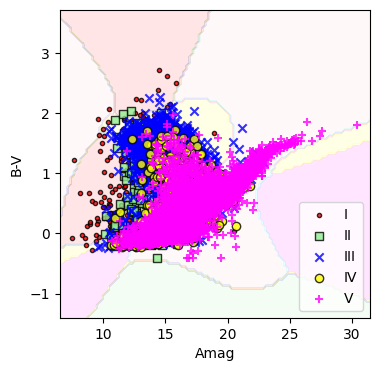

In [46]:
simple_plotting( problem3_logreg, good_data_raw, [ 'Amag', 'B-V' ], 'luminosity' )

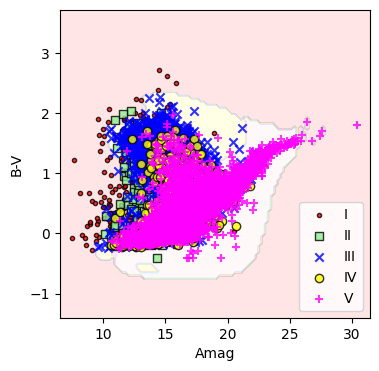

In [47]:
simple_plotting( problem3_svc, good_data_raw, [ 'Amag', 'B-V' ], 'luminosity' )

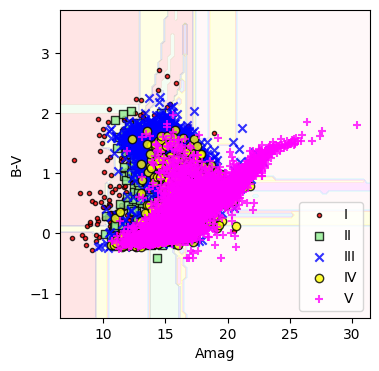

In [48]:
simple_plotting( problem3_tree, good_data_raw, [ 'Amag', 'B-V' ], 'luminosity' )

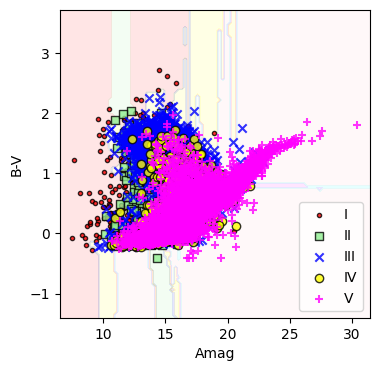

In [49]:
simple_plotting( problem3_forest, good_data_raw, [ 'Amag', 'B-V' ], 'luminosity' )

---
# Problem 4
---



In [50]:
(problem4_logreg,
 problem4_logreg_results
 ) = make_model(
        # data_transformer_scale,
        data_transformer_scale_poly,
        # data_transformer_scale_pca,
        # data_transformer_scale_lda,
        # data_transformer_scale_kpca,
        # data_transformer_scale_pca_poly,
        # data_transformer_scale_poly_pca,
        # data_transformer_scale_lda_poly,
        # data_transformer_scale_poly_lda,
        # data_transformer_scale_kpca_poly,
        # data_transformer_scale_poly_kpca,
        linear_model.LogisticRegression,
        q4_training_data, q4_testing_data,
        'LogisticRegression_lbfgs',
        transform_args={
                'n_components' : 3,  # pca & lda & kpca
                'degree'       : 5,  # poly & kpca
                'solver'       : 'svd',  # lda
                # 'solver' : 'lsqr', # lda
                # 'solver' : 'eigen', # lda
                # 'kernal':'linear', # kpca
                # 'kernal':'poly', # kpca
                # 'kernal':'rbf', # kpca
                # 'kernal':'sigmoid', # kpca
                # 'kernal':'cosine', # kpca
                },
        model_args={
                'class_weight' : 'balanced',
                'n_jobs'       : 8,
                'C'            : 1,  # logreg & SVC
                'gamma'        : 1,  # SVC
                'degree'       : 4,  # SVC
                # 'solver' : 'lbfgs', # logreg
                # 'solver' : 'liblinear', # logreg
                # 'solver' : 'newton-cg', # logreg
                # 'solver' : 'newton-cholesky', # logreg
                # 'solver' : 'sag', # logreg
                # 'solver' : 'saga', # logreg
                'kernel'       : 'rbf',  # SVC
                # 'kernel' : 'linear', # SVC
                # 'kernel' : 'poly', # SVC
                # 'kernel' : 'sigmoid', # SVC
                # 'criterion':'gini', # tree & forest
                'criterion'    : 'entropy',  # tree & forest
                # 'criterion':'log_loss', # tree & forest
                'max_depth'    : 100,  # tree & forest
                'n_estimators' : 100,  # tree
                'max_features' : 3,  # tree & forest
                # 'max_features' : 'sqrt', # tree & forest
                # 'max_features' : 'log2', # tree & forest
                }
        )
print( model_scoring( *problem4_logreg_results,
                      # format='html'
                      ) )

           LogisticRegression_lbfgs    Accuracy    Precision    R score    Mean Square Error
-------------------------------------  ----------  -----------  ---------  -------------------
Training Scores                        91.762%     91.819%      65.798%    8.238%
Testing Scores                         91.805%     91.869%      65.897%    8.195%



In [51]:
(problem4_svc,
 problem4_svc_results
 ) = make_model(
        # data_transformer_scale,
        data_transformer_scale_poly,
        # data_transformer_scale_pca,
        # data_transformer_scale_lda,
        # data_transformer_scale_kpca,
        # data_transformer_scale_pca_poly,
        # data_transformer_scale_poly_pca,
        # data_transformer_scale_lda_poly,
        # data_transformer_scale_poly_lda,
        # data_transformer_scale_kpca_poly,
        # data_transformer_scale_poly_kpca,
        svm.SVC,
        q4_training_data, q4_testing_data,
        'LogisticRegression_lbfgs',
        transform_args={
                'n_components' : 3,  # pca & lda & kpca
                'degree'       : 5,  # poly & kpca
                'solver'       : 'svd',  # lda
                # 'solver' : 'lsqr', # lda
                # 'solver' : 'eigen', # lda
                # 'kernal':'linear', # kpca
                # 'kernal':'poly', # kpca
                # 'kernal':'rbf', # kpca
                # 'kernal':'sigmoid', # kpca
                # 'kernal':'cosine', # kpca
                },
        model_args={
                'class_weight' : 'balanced',
                'n_jobs'       : 8,
                'C'            : 1,  # logreg & SVC
                'gamma'        : 1,  # SVC
                'degree'       : 4,  # SVC
                # 'solver' : 'lbfgs', # logreg
                # 'solver' : 'liblinear', # logreg
                # 'solver' : 'newton-cg', # logreg
                # 'solver' : 'newton-cholesky', # logreg
                # 'solver' : 'sag', # logreg
                # 'solver' : 'saga', # logreg
                'kernel'       : 'rbf',  # SVC
                # 'kernel' : 'linear', # SVC
                # 'kernel' : 'poly', # SVC
                # 'kernel' : 'sigmoid', # SVC
                # 'criterion':'gini', # tree & forest
                'criterion'    : 'entropy',  # tree & forest
                # 'criterion':'log_loss', # tree & forest
                'max_depth'    : 100,  # tree & forest
                'n_estimators' : 100,  # tree
                'max_features' : 3,  # tree & forest
                # 'max_features' : 'sqrt', # tree & forest
                # 'max_features' : 'log2', # tree & forest
                }
        )
print( model_scoring( *problem4_svc_results,
                      # format='html'
                      ) )

           LogisticRegression_lbfgs    Accuracy    Precision    R score    Mean Square Error
-------------------------------------  ----------  -----------  ---------  -------------------
Training Scores                        89.059%     89.935%      54.573%    10.941%
Testing Scores                         89.113%     89.978%      54.691%    10.887%



In [52]:
(problem4_tree,
 problem4_tree_results
 ) = make_model(
        # data_transformer_scale,
        data_transformer_scale_poly,
        # data_transformer_scale_pca,
        # data_transformer_scale_lda,
        # data_transformer_scale_kpca,
        # data_transformer_scale_pca_poly,
        # data_transformer_scale_poly_pca,
        # data_transformer_scale_lda_poly,
        # data_transformer_scale_poly_lda,
        # data_transformer_scale_kpca_poly,
        # data_transformer_scale_poly_kpca,
        tree.DecisionTreeClassifier,
        q4_training_data, q4_testing_data,
        'LogisticRegression_lbfgs',
        transform_args={
                'n_components' : 3,  # pca & lda & kpca
                'degree'       : 5,  # poly & kpca
                'solver'       : 'svd',  # lda
                # 'solver' : 'lsqr', # lda
                # 'solver' : 'eigen', # lda
                # 'kernal':'linear', # kpca
                # 'kernal':'poly', # kpca
                # 'kernal':'rbf', # kpca
                # 'kernal':'sigmoid', # kpca
                # 'kernal':'cosine', # kpca
                },
        model_args={
                'class_weight' : 'balanced',
                'n_jobs'       : 8,
                'C'            : 1,  # logreg & SVC
                'gamma'        : 1,  # SVC
                'degree'       : 4,  # SVC
                # 'solver' : 'lbfgs', # logreg
                # 'solver' : 'liblinear', # logreg
                # 'solver' : 'newton-cg', # logreg
                # 'solver' : 'newton-cholesky', # logreg
                # 'solver' : 'sag', # logreg
                # 'solver' : 'saga', # logreg
                'kernel'       : 'rbf',  # SVC
                # 'kernel' : 'linear', # SVC
                # 'kernel' : 'poly', # SVC
                # 'kernel' : 'sigmoid', # SVC
                # 'criterion':'gini', # tree & forest
                'criterion'    : 'entropy',  # tree & forest
                # 'criterion':'log_loss', # tree & forest
                'max_depth'    : 100,  # tree & forest
                'n_estimators' : 100,  # tree
                'max_features' : 3,  # tree & forest
                # 'max_features' : 'sqrt', # tree & forest
                # 'max_features' : 'log2', # tree & forest
                }
        )
print( model_scoring( *problem4_tree_results,
                      # format='html'
                      ) )

           LogisticRegression_lbfgs    Accuracy    Precision    R score    Mean Square Error
-------------------------------------  ----------  -----------  ---------  -------------------
Training Scores                        100.000%    100.000%     100.000%   0.000%
Testing Scores                         86.653%     86.654%      44.456%    13.347%



In [53]:
(problem4_forest,
 problem4_forest_results,
 ) = make_model(
        # data_transformer_scale,
        data_transformer_scale_poly,
        # data_transformer_scale_pca,
        # data_transformer_scale_lda,
        # data_transformer_scale_kpca,
        # data_transformer_scale_pca_poly,
        # data_transformer_scale_poly_pca,
        # data_transformer_scale_lda_poly,
        # data_transformer_scale_poly_lda,
        # data_transformer_scale_kpca_poly,
        # data_transformer_scale_poly_kpca,
        ensemble.RandomForestClassifier,
        q4_training_data, q4_testing_data,
        'LogisticRegression_lbfgs',
        transform_args={
                'n_components' : 3,  # pca & lda & kpca
                'degree'       : 5,  # poly & kpca
                'solver'       : 'svd',  # lda
                # 'solver' : 'lsqr', # lda
                # 'solver' : 'eigen', # lda
                # 'kernal':'linear', # kpca
                # 'kernal':'poly', # kpca
                # 'kernal':'rbf', # kpca
                # 'kernal':'sigmoid', # kpca
                # 'kernal':'cosine', # kpca
                },
        model_args={
                'class_weight' : 'balanced',
                'n_jobs'       : 8,
                'C'            : 1,  # logreg & SVC
                'gamma'        : 1,  # SVC
                'degree'       : 4,  # SVC
                # 'solver' : 'lbfgs', # logreg
                # 'solver' : 'liblinear', # logreg
                # 'solver' : 'newton-cg', # logreg
                # 'solver' : 'newton-cholesky', # logreg
                # 'solver' : 'sag', # logreg
                # 'solver' : 'saga', # logreg
                'kernel'       : 'rbf',  # SVC
                # 'kernel' : 'linear', # SVC
                # 'kernel' : 'poly', # SVC
                # 'kernel' : 'sigmoid', # SVC
                # 'criterion':'gini', # tree & forest
                'criterion'    : 'entropy',  # tree & forest
                # 'criterion':'log_loss', # tree & forest
                'max_depth'    : 100,  # tree & forest
                'n_estimators' : 100,  # tree
                'max_features' : 3,  # tree & forest
                # 'max_features' : 'sqrt', # tree & forest
                # 'max_features' : 'log2', # tree & forest
                }
        )
print( model_scoring( *problem4_logreg_results,
                      # format='html'
                      ) )

           LogisticRegression_lbfgs    Accuracy    Precision    R score    Mean Square Error
-------------------------------------  ----------  -----------  ---------  -------------------
Training Scores                        91.762%     91.819%      65.798%    8.238%
Testing Scores                         91.805%     91.869%      65.897%    8.195%



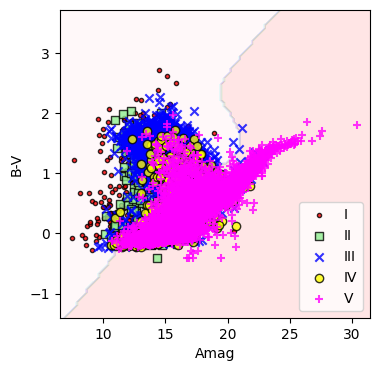

In [54]:
simple_plotting( problem4_logreg, good_data_raw, [ 'Amag', 'B-V' ], 'luminosity' )

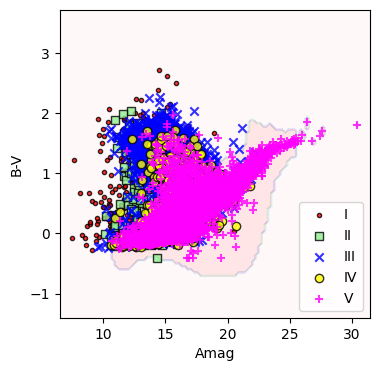

In [55]:
simple_plotting( problem4_svc, good_data_raw, [ 'Amag', 'B-V' ], 'luminosity' )

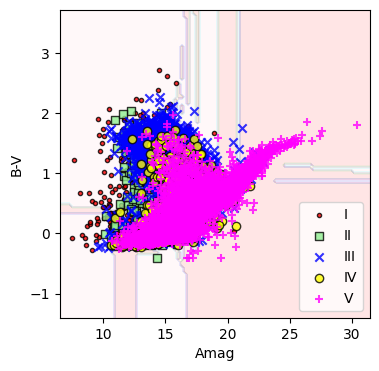

In [56]:
simple_plotting( problem4_tree, good_data_raw, [ 'Amag', 'B-V' ], 'luminosity' )

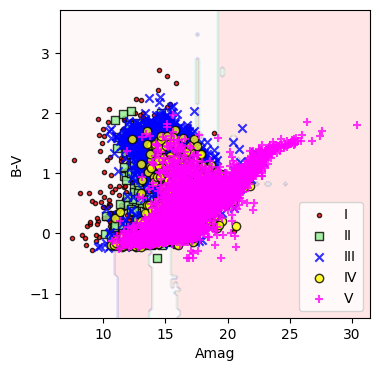

In [57]:
simple_plotting( problem4_forest, good_data_raw, [ 'Amag', 'B-V' ], 'luminosity' )

Last Step Outputs

In [58]:
#### Step 6 #######################################################################################################################

question_features_VmagPlxBV = exam_question_data[ [ 'Vmag', 'Plx', 'B-V' ] ]
question_features_AmagBV = exam_question_data[ [ 'Amag', 'B-V' ] ]

In [59]:
exam_question_data[ 'q1_LogisticRegression_lbfgs'
] = problem1_logreg.predict( question_features_VmagPlxBV )
exam_question_data[ 'q1_SVC_rbf'
] = problem1_svc.predict( question_features_VmagPlxBV )
exam_question_data[ 'q1_DecisionTreeClassifier_gini'
] = problem1_tree.predict( question_features_VmagPlxBV )
exam_question_data[ 'q1_RandomForestClassifier_gini'
] = problem1_forest.predict( question_features_VmagPlxBV )

In [60]:
exam_question_data[ 'q2_LogisticRegression_lbfgs'
] = problem2_logreg.predict( question_features_VmagPlxBV )
exam_question_data[ 'q2_SVC_rbf'
] = problem2_svc.predict( question_features_VmagPlxBV )
exam_question_data[ 'q2_DecisionTreeClassifier_gini'
] = problem2_tree.predict( question_features_VmagPlxBV )
exam_question_data[ 'q2_RandomForestClassifier_gini'
] = problem2_forest.predict( question_features_VmagPlxBV )

In [61]:
exam_question_data[ 'q3_LogisticRegression_lbfgs'
] = problem3_logreg.predict( question_features_AmagBV )
exam_question_data[ 'q3_SVC_rbf'
] = problem3_svc.predict( question_features_AmagBV )
exam_question_data[ 'q3_DecisionTreeClassifier_gini'
] = problem3_tree.predict( question_features_AmagBV )
exam_question_data[ 'q3_RandomForestClassifier_gini'
] = problem3_forest.predict( question_features_AmagBV )

In [62]:
exam_question_data[ 'q4_LogisticRegression_lbfgs'
] = problem4_logreg.predict( question_features_AmagBV )
exam_question_data[ 'q4_SVC_rbf'
] = problem4_svc.predict( question_features_AmagBV )
exam_question_data[ 'q4_DecisionTreeClassifier_gini'
] = problem4_tree.predict( question_features_AmagBV )
exam_question_data[ 'q4_RandomForestClassifier_gini'
] = problem4_forest.predict( question_features_AmagBV )

In [63]:
exam_question_data.to_csv( exam_question_outfile )
end_time = time( )

In [64]:
duration_in_seconds = end_time - start_time

In [65]:
print( tabulate( [ ("Total computation time: \n",
                    f"mm:ss.s = {duration_in_seconds // 60:.1n}:{duration_in_seconds % 60:.1f}")
                   ] ) )

-----------------------  -------------------
Total computation time:  mm:ss.s = 1e+01:7.8
-----------------------  -------------------
